In [432]:
import numpy as np
from numpy.typing import NDArray
from typing import List, Tuple
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import torch
from torch.optim import Optimizer
from torch import Tensor

In [433]:
with open('../dirs.yaml', 'r') as file:
    dirs = yaml.safe_load(file)['homework-1']
    X = pd.read_csv(dirs['train']['x'])
    y = pd.read_csv(dirs['train']['y'])
    
df = pd.merge(X, y, on='Unnamed: 0').drop(columns=['Unnamed: 0'])

# Задание 1

$$
\hat{y} = \sigma(x^Tw + b) \\
L = -\frac{1}{N}\sum\limits_{i}(y_ilog(\hat{y}_i)+(1-y_i)log(1-\hat{y}_i)) \\
\frac{\partial L}{\partial w} = -\frac{1}{N}\sum\limits_{i}\frac{\partial L}{\partial \hat{y}_i}\frac{\partial \hat{y}_i}{\partial z_i}\frac{\partial z_i}{\partial w}=-\frac{1}{N}\sum\limits_{i}(\frac{y_i}{\hat{y}_i} - \frac{ 1- y_i}{1 - \hat{y}_i})(\hat{y_i}(1-\hat{y}_i))x_i^T = \frac{1}{N}X^T(\hat{y}-y) \\ 
\frac{\partial L}{\partial b} = -\frac{1}{N}\sum\limits_{i}\frac{\partial L}{\partial \hat{y}_i}\frac{\partial \hat{y}_i}{\partial z_i}\frac{\partial z_i}{\partial b} = \frac{1}{N}(\hat{y}-y)
$$

In [434]:
def sigmoid(x: NDArray) -> NDArray:
    return 1 / (1 + np.exp(-x))

def sgd(X: NDArray,
        y: NDArray,
        weights: NDArray,
        bias: float,
        lr: float,
        batch_size: int) -> Tuple[NDArray, float, float]:
    
    N = X.shape[0]
    indices = np.arange(N)
    np.random.shuffle(indices)
    loss = 0.0
    eps = 1e-5
    for start_idx in range(0, N, batch_size):
        idxs = indices[start_idx: start_idx + batch_size]
        X_batch = X[idxs]
        y_batch = y[idxs]
        y_pred = sigmoid(X_batch @ weights + bias)
        loss += -np.sum(y_batch * np.log(y_pred + eps) + (1 - y_batch) * np.log(1 - y_pred + eps))
        dy = (y_pred - y_batch) / batch_size
        bias_grad = np.sum(dy)
        weights_grad = X_batch.T @ dy
        weights -= lr * weights_grad
        bias -= lr * bias_grad
        
    loss /= (N / batch_size)
    
    return weights, bias, loss
        
        
def train_neuron(X: NDArray,
                 y: NDArray,
                 weights: NDArray,
                 bias: float,
                 lr: float = 0.1,
                 batch_size: int = 8,
                 epochs: int = 100
                 ) -> Tuple[NDArray, float, List]:
    
    N = X.shape[0]
    losses = []
    eps = 1e-5
    for epoch in range(epochs):
        weights, bias, loss = sgd(X, y, weights, bias, lr, batch_size)
        losses.append(np.round(loss, 4))
        
    return weights, bias, losses

weights: [-0.00149024  0.00836707 -0.00315593 -0.00545393 -0.00252606 -0.00553515
 -0.00421633 -0.00480355 -0.00482879 -0.00437584 -0.00383759 -0.00340904
 -0.00449706 -0.00643701 -0.04142863  0.01113849  0.11444474 -0.011956
  0.07077423  0.0165318   0.020293    0.01610095  0.00506713  0.0319446
 -0.01070055 -0.08423343  0.05691734 -0.04365838 -0.02397545 -0.01498472
 -0.00392014  0.00024417 -0.00368134 -0.00139248 -0.00188694 -0.00328494
  0.03319567  0.13933881 -0.01221258  0.0295426   0.00259869 -0.00874585
 -0.00157437 -0.01175798 -0.00495749 -0.00584566  0.03473697 -0.03220672
  0.02244048 -0.01227926 -0.01665284 -0.00558413 -0.00015201 -0.01979497
  0.00415697 -0.00648646  0.0327158   0.00655439  0.03602941 -0.02221223
 -0.00790167  0.00421631 -0.00588585  0.00575939  0.02458385 -0.0215352
  0.00527648  0.00740055 -0.01053741 -0.00426308 -0.0188516  -0.01708424
  0.01329728 -0.01092216 -0.00754029  0.00063643  0.01333919 -0.01565951
 -0.0092462   0.00016918 -0.00400606  0.012488

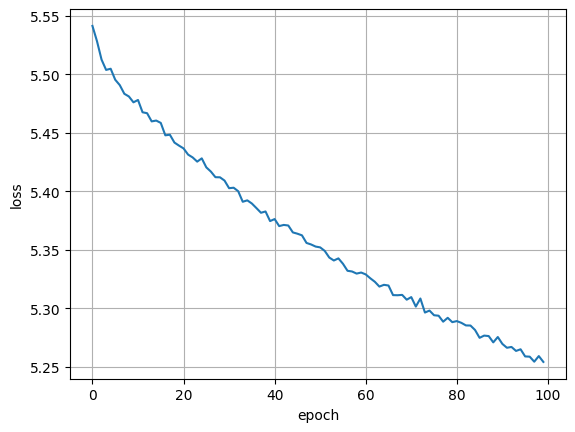

In [435]:
df_bin = df[df['year'].isin([1980, 1981])]
X = df_bin.drop(columns=['year']).to_numpy()
y = df_bin['year'].to_numpy() - 1980
X = (X - X.mean()) / X.std()
weights = np.zeros((X.shape[1],))
bias = 0.0

weights, bias, losses = train_neuron(X, y, weights, bias, lr=1e-3, epochs=100)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.plot(losses)
print(f"weights: {weights}\nbias: {bias}")

# Задание 2

In [436]:
class Stack:
    def __init__(self):
        self.data = [None]
        self.size = 0
        self.capacity = 1
        
    def empty(self):
        return self.size == 0
    
    def put(self, item):
        if self.size == self.capacity:
            self.data += [None] * self.capacity
            self.capacity *= 2
        self.data[self.size] = item
        self.size += 1
        
    def get(self):
        if self.empty():
            return None
        self.size -= 1
        item = self.data[self.size]
        self.data[self.size] = None
        return item
    def __repr__(self):
        return f"{self.data}"

In [437]:
class Scalar:
    def __init__(self, data: float, _children=(), _op='input'):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Scalar(data={self.data}, grad={self.grad})"

    def __add__(self, other: "Scalar") -> "Scalar":
        other = other if isinstance(other, Scalar) else Scalar(other)
        node = Scalar(self.data + other.data, (self, other), 'add')

        def _backward():
            self.grad += node.grad
            other.grad += node.grad
        node._backward = _backward

        return node

    def __mul__(self, other: "Scalar") -> "Scalar":
        node = Scalar(self.data * other.data, (self, other), 'mul')
        def _backward():
            self.grad += other.data * node.grad
            other.grad += self.data * node.grad
        node._backward = _backward
        
        return node
    

    def relu(self) -> "Scalar":
        relu = lambda x: x if x > 0.0 else 0.0
        node = Scalar(relu(self.data), (self,), 'relu')
        def _backward():
            drelu = lambda x: 1.0 if x > 0.0 else 0.0
            self.grad += drelu(self.data) * node.grad
        node._backward = _backward
        
        return node
    
    def backward(self):
        topo = []
        visited = set()
        stack = Stack()
        stack.put(self)
        temp_mark = set()
        while not stack.empty():
            node = stack.get()

            if node in visited:
                continue

            if node in temp_mark:
                visited.add(node)
                topo.append(node)
            else:
                temp_mark.add(node)
                stack.put(node)
                for child in node._prev:
                    if child not in visited:
                        stack.put(child)
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()
                        
        

In [438]:
a = Scalar(2)
b = Scalar(-3)
c = Scalar(10)
d = a + b * c
e = d.relu()
e.backward()
print(a, b, c, d, e)

Scalar(data=2, grad=0.0) Scalar(data=-3, grad=0.0) Scalar(data=10, grad=0.0) Scalar(data=-28, grad=0.0) Scalar(data=0.0, grad=1.0)


In [439]:
a = Scalar(2)
b = Scalar(3)
c = Scalar(10)
d = a + b * c
e = d.relu()
e.backward()
print(a, b, c, d, e)

Scalar(data=2, grad=1.0) Scalar(data=3, grad=10.0) Scalar(data=10, grad=3.0) Scalar(data=32, grad=1.0) Scalar(data=32, grad=1.0)


In [440]:
a = Scalar(2)
b = Scalar(3)
c = a * b
d = a + c 
e = c * d 
e.backward()
print(a, b, c, d, e)

Scalar(data=2, grad=48.0) Scalar(data=3, grad=28.0) Scalar(data=6, grad=14.0) Scalar(data=8, grad=6.0) Scalar(data=48, grad=1.0)


# Задание 3

In [441]:
class AdamW(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(AdamW, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data
                state = self.state[p]

                if 'step' not in state:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                p.data.mul_(1 - group['lr'] * group['weight_decay'])
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                denom = (exp_avg_sq.sqrt() / bias_correction2).add_(group['eps']).sqrt()
                step_size = group['lr'] / bias_correction1
                p.data.addcdiv_(exp_avg, denom, value=-step_size)

In [446]:
def sigmoid(x: Tensor) -> Tensor:
    return 1 / (1 + torch.exp(-x))

def train_neuron(X: Tensor,
                 y: Tensor,
                 weights: Tensor,
                 bias: Tensor,
                 lr: float = 0.1,
                 batch_size: int = 8,
                 epochs: int = 100) -> Tuple[Tensor, Tensor, List[float]]:

    optimizer = AdamW([weights, bias], lr=lr, weight_decay=1e-2)
    N = X.shape[0]
    losses: List[float] = []

    for epoch in range(epochs):
        indices = torch.randperm(N)
        epoch_loss = 0.0

        for start_idx in range(0, N, batch_size):
            idxs = indices[start_idx: start_idx + batch_size]
            X_batch = X[idxs]
            y_batch = y[idxs].view(-1, 1)
            y_pred = sigmoid(X_batch @ weights.view(-1,1) + bias)
            eps = 1e-5
            batch_loss = -torch.sum(y_batch * torch.log(y_pred + eps) + 
                                    (1 - y_batch) * torch.log(1 - y_pred + eps))
            batch_loss /= X_batch.shape[0]

            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            epoch_loss += batch_loss.item() * X_batch.shape[0]

        losses.append(round(epoch_loss / N, 4))

    return weights, bias, losses


/tmp/ipykernel_58415/1468197309.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_58415/1468197309.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32).view(-1, 1)


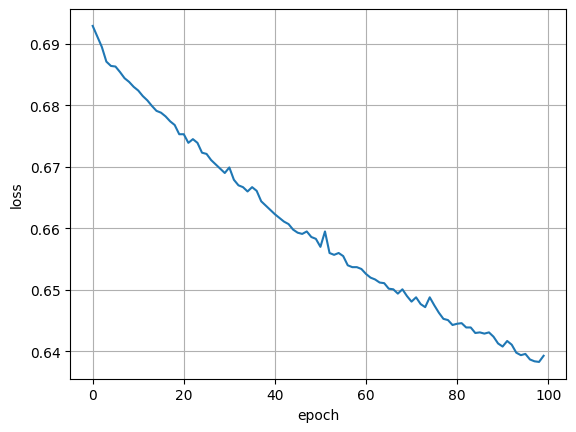

weights: tensor([-0.0033,  0.0384, -0.0098, -0.0158, -0.0051, -0.0144, -0.0102, -0.0124,
        -0.0137, -0.0114, -0.0092, -0.0077, -0.0150, -0.0198, -0.0502,  0.0070,
         0.1374, -0.0236,  0.1029,  0.0281,  0.0358,  0.0340,  0.0117,  0.0770,
        -0.0280, -0.0991,  0.0944, -0.1224, -0.0701, -0.0478, -0.0108,  0.0013,
        -0.0104,  0.0017, -0.0032,  0.0018,  0.0755,  0.2417, -0.0177,  0.0836,
         0.0105, -0.0269,  0.0035, -0.0417, -0.0132, -0.0161,  0.0771, -0.0760,
         0.0550, -0.0415, -0.0520, -0.0134,  0.0051, -0.0673,  0.0206, -0.0084,
         0.0646,  0.0309,  0.1102, -0.0540, -0.0243,  0.0209, -0.0145,  0.0146,
         0.0600, -0.0635,  0.0198,  0.0285, -0.0347, -0.0112, -0.0593, -0.0399,
         0.0400, -0.0278, -0.0194,  0.0073,  0.0377, -0.0544, -0.0176,  0.0093,
        -0.0097,  0.0418, -0.0217,  0.0316,  0.0027, -0.0251, -0.0295, -0.0085,
        -0.0372, -0.0249], requires_grad=True)
bias: tensor([0.0165], requires_grad=True)


In [447]:
weights = np.zeros((X.shape[1],))
bias = 0.0
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
weights = torch.tensor(weights, dtype=torch.float32, requires_grad=True)
bias = torch.tensor([bias], dtype=torch.float32, requires_grad=True)
weights, bias, losses = train_neuron(
    X, y, weights, bias,
    lr=1e-3,
    batch_size=8,
    epochs=100
)

plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.show()

print(f"weights: {weights}\nbias: {bias}")
